### Printing out the Branches in the data.

In [2]:
import ROOT
f = ROOT.TFile.Open("/mnt/data/eos/run910/run910.root")
events = f.Get("events")
events.Print()

******************************************************************************
*Tree    :events    : events                                                 *
*Entries :   770254 : Total =     12031892079 bytes  File  Size = 3714625685 *
*        :          : Tree compression factor =   3.24                       *
******************************************************************************
*Br    0 :event_number : event_number/I                                      *
*Entries :   770254 : Total  Size=    3131849 bytes  File Size  =    1138434 *
*Baskets :      500 : Basket Size=      32000 bytes  Compression=   2.74     *
*............................................................................*
*Br    1 :nhit      : nhit/I                                                 *
*Entries :   770254 : Total  Size=    3127817 bytes  File Size  =    1077375 *
*Baskets :      500 : Basket Size=      32000 bytes  Compression=   2.89     *
*...................................................

### PMT Hits Map ###
The code block will open the root data file and grab the branches (some of these are vectors).<br>
Then loop through each of the event and hit and make a histogram out of the number of hits for each PMT.<br>
Then the map of Board# vs Channel are made.<br>
Board 14 Channel 12 to Board 15 Channel 14 are those will Muon paddle outputs.<br>

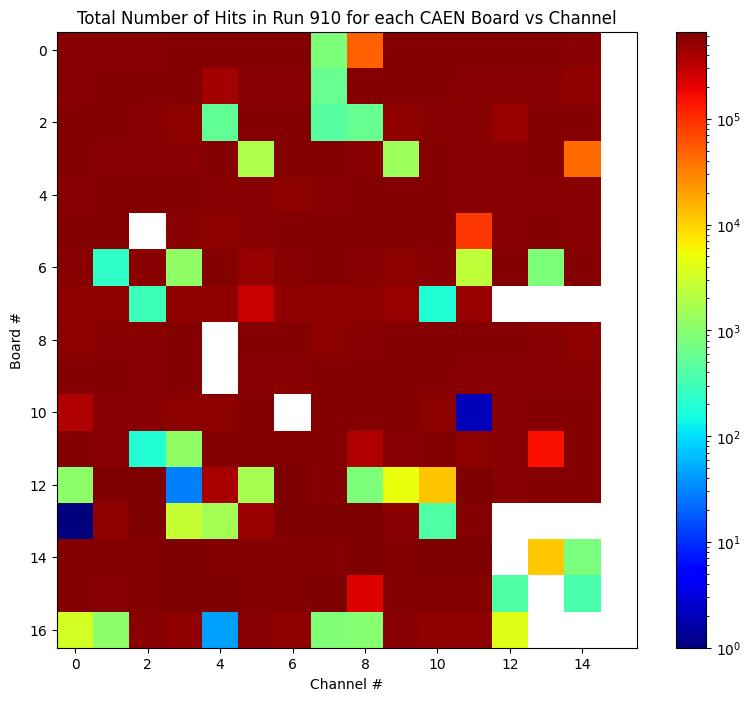

nMuonHits nTotalHits nMuonHits/nTotalHits
1275412.0 118209506.0 0.01078941993040729
nhits in B14C11-B15-C14
[[6.36878e+05 0.00000e+00 1.14960e+04 7.75000e+02]
 [6.25503e+05 4.06000e+02 0.00000e+00 3.54000e+02]]


In [3]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## SET THE RUN NUMBER!
run_number = "910" # New Muon run with increase pulse high. MTCA threshold ~ 1000
#run_number = "357" #New Digitizer Configuration with 30 samples additional readout.
#run_number = "408" #6 hour run with MTCA@120mV prescale of 10!
#run_number = "417" #12 hour run no prescale

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
charge = rdf.AsNumpy(columns=["charge"])["charge"]
deltat = rdf.AsNumpy(columns=["deltat"])["deltat"]

#print(len(charge[0]))
#print(nhit[0])

PMTHits = np.zeros([17,16])
#print(PMTHits.shape)
for iEvt in range(0,len(event_number)):
    #print(len(board[aEvt]),len(channel[aEvt]), nhit[aEvt])
    for iHit in range(0,len(board[iEvt])):
        #print(board[iEvt][iHit])
        PMTHits[board[iEvt][iHit],channel[iEvt][iHit]]=PMTHits[board[iEvt][iHit],channel[iEvt][iHit]]+1

plt.figure(figsize=(10,8))
plt.imshow(PMTHits, cmap='jet',norm=colors.LogNorm())
plt.title("Total Number of Hits in Run "+run_number+" for each CAEN Board vs Channel")
plt.xlabel("Channel #")
plt.ylabel("Board #")
plt.colorbar()
plt.show()

nMuonHits = np.sum(PMTHits[14:16,11:15])
nTotalHits= np.sum(PMTHits)
print("nMuonHits nTotalHits nMuonHits/nTotalHits")
print(nMuonHits,nTotalHits,nMuonHits/nTotalHits)
print("nhits in B14C11-B15-C14")
print(PMTHits[14:16,11:15])


### Now, let's see if we can get coincidences of the paddles.
The code opens the file, grab the branches<br>
Then it loops through each event.<br>
    Create a 2x3 array (for the 6 powered up muon paddles) for each event.<br>
    Then fill the array with whether or not a hit occurred in the paddles.<br>
    Then it looks in the array to see if there are coincidences between top, middle, bottom paddles<br>

Total Events= 3464681  Zeros=  2528746  Singles=  15257  Doubles=  1493  Triples= 415


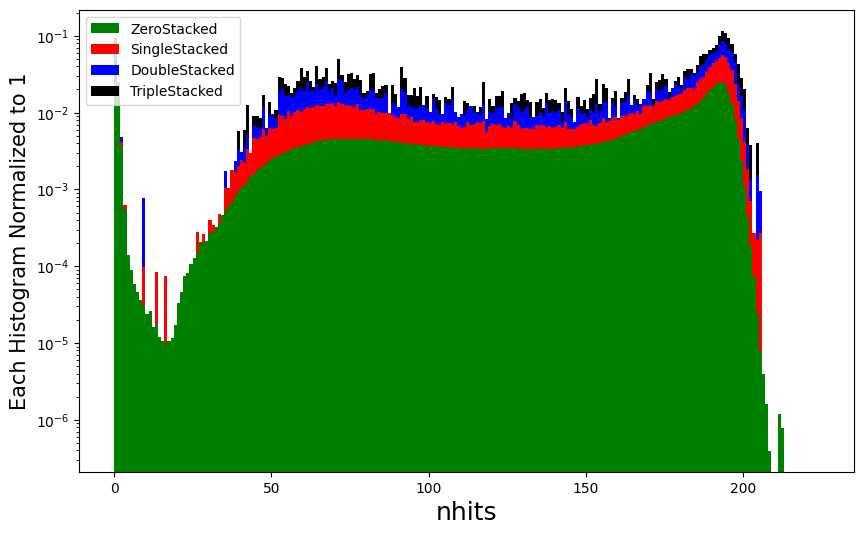

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#run_number = "357"
#run_number = "408" #6 hour run with MTCA@120mV prescale of 10
run_number = "417" #6 hour run with no prescale

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
charge = rdf.AsNumpy(columns=["charge"])["charge"]

nZero=0
nSingle=0
nDouble=0
nTriple=0

nhitZero = []
nhitSingle = []
nhitDouble = []
nhitTriple = []


for iEvt in range(0,len(event_number)):
    MuonHits = np.zeros([2,3])    
    for iHit in range(0,len(board[iEvt])):
        if  (board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 12):
           MuonHits[0,0]=1
        elif(board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 13):
           MuonHits[0,1]=1      
        elif(board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 14):
           MuonHits[0,2]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 12):
           MuonHits[1,0]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 13):
           MuonHits[1,1]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 14):
           MuonHits[1,2]=1

    if(np.sum(MuonHits)==0): 
        nZero+=1
        nhitZero.append(nhit[iEvt])

    if(MuonHits[1,0] or MuonHits[1,2]):
        nSingle+=1
        nhitSingle.append(nhit[iEvt])
        if(MuonHits[1,1] or MuonHits[0,2]):
            #print("Double!",iEvt)
            nDouble+=1
            nhitDouble.append(nhit[iEvt])
            if(MuonHits[0,0] or MuonHits[0,1]):
                #print("Triple!",iEvt)
                nTriple+=1
                nhitTriple.append(nhit[iEvt])

print("Total Events=",len(event_number)," Zeros= ",nZero," Singles= ",nSingle," Doubles= ",nDouble, " Triples=",nTriple)
plt.figure(figsize=(10,6))

weightsZero = np.ones_like(nhitZero) / len(nhitZero)
weightsSingle = np.ones_like(nhitSingle) / len(nhitSingle)
weightsDouble = np.ones_like(nhitDouble) / len(nhitDouble)
weightsTriple = np.ones_like(nhitTriple) / len(nhitTriple)

plt.hist([nhitZero,nhitSingle,nhitDouble,nhitTriple],weights=[weightsZero,weightsSingle,weightsDouble,weightsTriple],label=["ZeroStacked","SingleStacked","DoubleStacked","TripleStacked"],
         color=["green","red","blue","black"],bins=range(0,225), stacked=True)
#plt.hist(nhitZero,color="green",alpha=0.7,label="ZeroNOTStacked",bins=range(0,225),density=True)

plt.xlabel("nhits",fontsize=18)
plt.ylabel("Each Histogram Normalized to 1",fontsize=15)
plt.legend()
plt.yscale('log')
plt.ylim(1e-4,2e-1)
plt.show()

Total Events= 4952309  Zeros=  3344395  Singles=  166322  Doubles=  71750  Triples= 19979


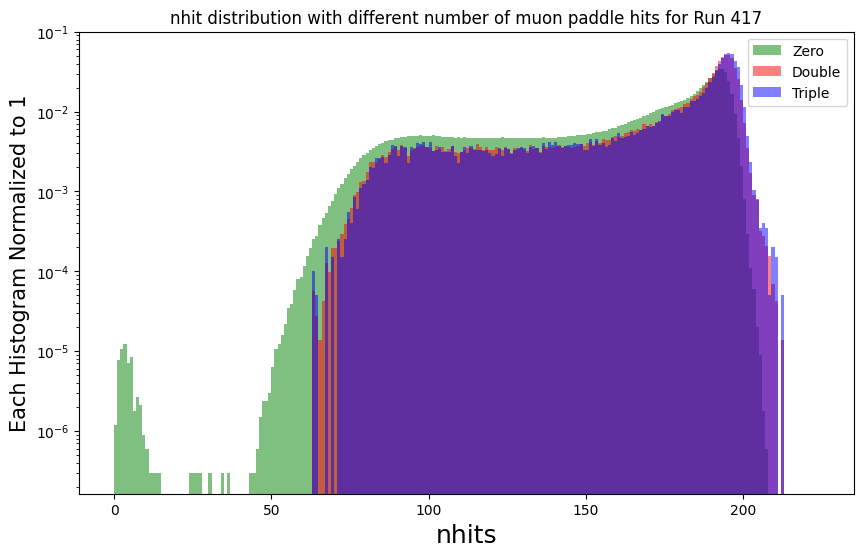

In [18]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#run_number = "357"
#run_number = "408" #6 hour run with MTCA@120mV prescale of 10
run_number = "417" #6 hour run with no prescale

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
charge = rdf.AsNumpy(columns=["charge"])["charge"]

nZero=0
nSingle=0
nDouble=0
nDoubleOnly=0
nTriple=0

nhitZero = []
nhitSingle = []
nhitDouble = []
nhitDoubleOnly = []
nhitTriple = []


for iEvt in range(0,len(event_number)):
    MuonHits = np.zeros([2,3])    
    for iHit in range(0,len(board[iEvt])):
        if  (board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 12):
           MuonHits[0,0]=1
        elif(board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 13):
           MuonHits[0,1]=1      
        elif(board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 14):
           MuonHits[0,2]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 12):
           MuonHits[1,0]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 13):
           MuonHits[1,1]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 14):
           MuonHits[1,2]=1

    if(np.sum(MuonHits)==0): 
        nZero+=1
        nhitZero.append(nhit[iEvt])

    if(MuonHits[1,0] or MuonHits[1,2]):
        nSingle+=1
        nhitSingle.append(nhit[iEvt])
        if(MuonHits[1,1] or MuonHits[0,2]):
            #print("Double!",iEvt)
            nDouble+=1
            nhitDouble.append(nhit[iEvt])
            if(MuonHits[0,0] or MuonHits[0,1]):
                #print("Triple!",iEvt)
                nTriple+=1
                nhitTriple.append(nhit[iEvt])
            else:
                nDoubleOnly+=1
                nhitDoubleOnly.append(nhit[iEvt])
        

print("Total Events=",len(event_number)," Zeros= ",nZero," Singles= ",nSingle," Doubles= ",nDouble, " Triples=",nTriple)

plt.figure(figsize=(10,6))

weightsZero = np.ones_like(nhitZero) / len(nhitZero)
weightsSingle = np.ones_like(nhitSingle) / len(nhitSingle)
weightsDouble = np.ones_like(nhitDouble) / len(nhitDouble)
weightsTriple = np.ones_like(nhitTriple) / len(nhitTriple)

plt.hist(nhitZero,color="green",alpha=0.5,label="Zero",bins=range(0,225),density=True)
plt.hist(nhitDouble,color="red",alpha=0.5,label="Double",bins=range(0,225),density=True)
plt.hist(nhitTriple,color="blue",alpha=0.5,label="Triple",bins=range(0,225),density=True)

plt.title("nhit distribution with different number of muon paddle hits for Run "+run_number)
plt.xlabel("nhits",fontsize=18)
plt.ylabel("Each Histogram Normalized to 1",fontsize=15)
plt.legend()
plt.yscale('log')
#plt.ylim(1e-4,2e-1)
plt.show()

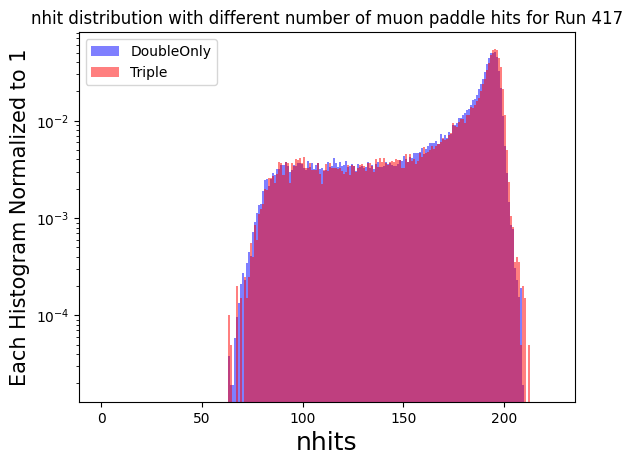

In [19]:
#plt.hist(nhitZero,color="red",alpha=0.5,label="Zero",bins=range(0,225),density=True)
plt.hist(nhitDoubleOnly,color="blue",alpha=0.5,label="DoubleOnly",bins=range(0,225),density=True)
plt.hist(nhitTriple,color="red",alpha=0.5,label="Triple",bins=range(0,225),density=True)

plt.title("nhit distribution with different number of muon paddle hits for Run "+run_number)
plt.xlabel("nhits",fontsize=18)
plt.ylabel("Each Histogram Normalized to 1",fontsize=15)
plt.legend()
plt.yscale('log')
#plt.ylim(1e-4,2e-1)
plt.show()

### Plotting Delta T for events with and without muon hits

Total Events= 3464681  Zeros=  2528745  Singles=  15257  Doubles=  1493  Triples= 415


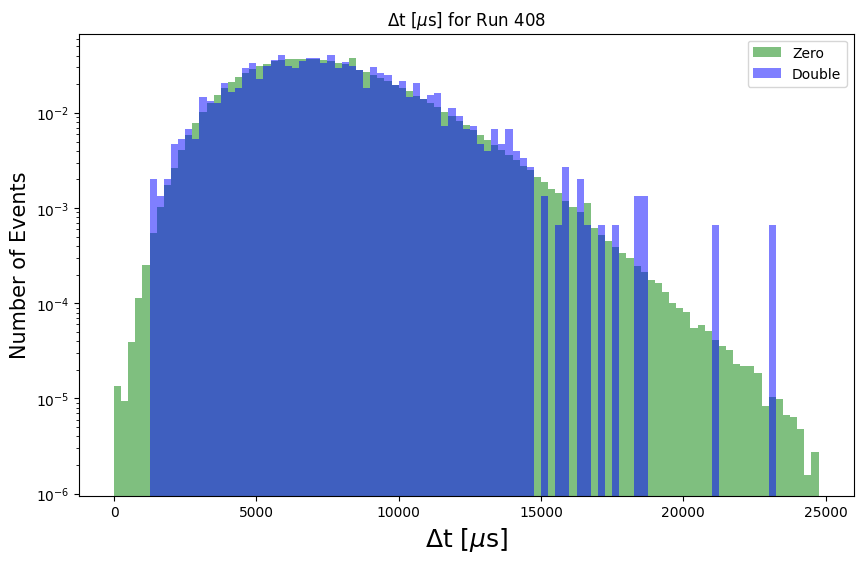

In [3]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#run_number = "357" #
#run_number = "408" #6 hour run with MTCA@120mV prescale of 10
run_number = "417" #6 hour run with no prescale

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
charge = rdf.AsNumpy(columns=["charge"])["charge"]
deltat = rdf.AsNumpy(columns=["deltat"])["deltat"]

nZero=0
nSingle=0
nDouble=0
nTriple=0

deltatZero = []
deltatSingle = []
deltatDouble = []
deltatTriple = []


for iEvt in range(0,len(event_number)-1):
    MuonHits = np.zeros([2,3])    
    for iHit in range(0,len(board[iEvt])):
        if  (board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 12):
           MuonHits[0,0]=1
        elif(board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 13):
           MuonHits[0,1]=1      
        elif(board[iEvt][iHit] == 14 and channel[iEvt][iHit] == 14):
           MuonHits[0,2]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 12):
           MuonHits[1,0]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 13):
           MuonHits[1,1]=1
        elif(board[iEvt][iHit] == 15 and channel[iEvt][iHit] == 14):
           MuonHits[1,2]=1

    if(np.sum(MuonHits)==0): 
        nZero+=1
        deltatZero.append(deltat[iEvt+1])

    if(MuonHits[1,0] or MuonHits[1,2]):
        nSingle+=1
        deltatSingle.append(deltat[iEvt+1])
        if(MuonHits[1,1] or MuonHits[0,2]):
            #print("Double!",iEvt)
            nDouble+=1
            deltatDouble.append(deltat[iEvt+1])
            if(MuonHits[0,0] or MuonHits[0,1]):
                #print("Triple!",iEvt)
                nTriple+=1
                deltatTriple.append(deltat[iEvt+1])

print("Total Events=",len(event_number)," Zeros= ",nZero," Singles= ",nSingle," Doubles= ",nDouble, " Triples=",nTriple)
plt.figure(figsize=(10,6))

weightsZero = np.ones_like(deltatZero) / len(deltatZero)
weightsSingle = np.ones_like(deltatSingle) / len(deltatSingle)
weightsDouble = np.ones_like(deltatDouble) / len(deltatDouble)
weightsTriple = np.ones_like(deltatTriple) / len(deltatTriple)

plt.hist(deltatZero,weights=weightsZero,label="Zero",color="green",bins=range(0,25000,250),alpha=0.5)
plt.hist(deltatDouble,weights=weightsDouble,label="Double",color="blue",bins=range(0,25000,250),alpha=0.5)
         
#plt.hist(nhitZero,color="green",alpha=0.7,label="ZeroNOTStacked",bins=range(0,225),density=True)

plt.title("$\Delta$t [$\mu$s] for Run "+run_number)
plt.xlabel("$\Delta$t [$\mu$s]",fontsize=18)
plt.ylabel("Number of Events",fontsize=15)
plt.legend()
plt.yscale('log')
plt.show()

## Code for Run 417

[ 1.00671306e+05  1.00000000e+06 -2.00000000e+00]


/tmp/ipykernel_598659/704660717.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  paramfit, paramErr = curve_fit(myfit,bin_centers,#[5:15],


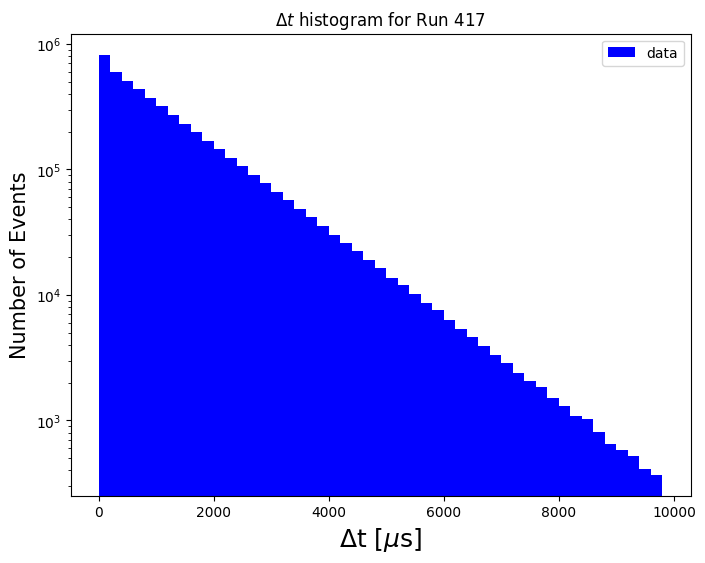

In [22]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#run_number = "312" #
#run_number = "408" #6 hour run with MTCA@120mV prescale of 10
run_number = "417" #6 hour run with no prescale

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
charge = rdf.AsNumpy(columns=["charge"])["charge"]
deltat = rdf.AsNumpy(columns=["deltat"])["deltat"]

#count, bin_edges = np.histogram(deltat, bins=np.arange(1,10,0.2))
count, bin_edges = np.histogram(deltat, bins=np.arange(1,10001,200))
bin_centers =[]
for ie in range(1,len(bin_edges)):
    bin_centers.append((bin_edges[ie]+bin_edges[ie-1])/2)

from scipy.optimize import curve_fit
# Create the fit as a function
# x = dependent var
# a b c are the parameters
def myfit(x,a,b,tau):
    return a+b*np.exp(x/tau)

param0 = (0,1000000,-2)
paramfit, paramErr = curve_fit(myfit,bin_centers,#[5:15],
                               count,#[5:15],
                               param0)

print(paramfit)
#paramfit[2]=2.2
fitfun = myfit(bin_centers,paramfit[0],paramfit[1],paramfit[2])


plt.figure(figsize=(8,6))
plt.title("$\Delta t$ histogram for Run "+run_number)
plt.xlabel("$\Delta t [\mu s]$")
plt.ylabel("Events Per Bin")
#plt.xlim(0,10)
plt.yscale('log')
#plt.plot(bin_centers,fitfun,"r",label="A+B*exp(t/tau)")
#plt.bar(bin_centers, count, color ='blue', width = 0.2, label="data")
plt.bar(bin_centers, count, color ='blue', width = 200, label="data")
plt.xlabel("$\Delta$t [$\mu$s]",fontsize=18)
plt.ylabel("Number of Events",fontsize=15)
plt.legend()
#plt.yscale('log')
plt.show()

### Let's cut on delta T < 10 and see what the nhit / charge histogram looks like.

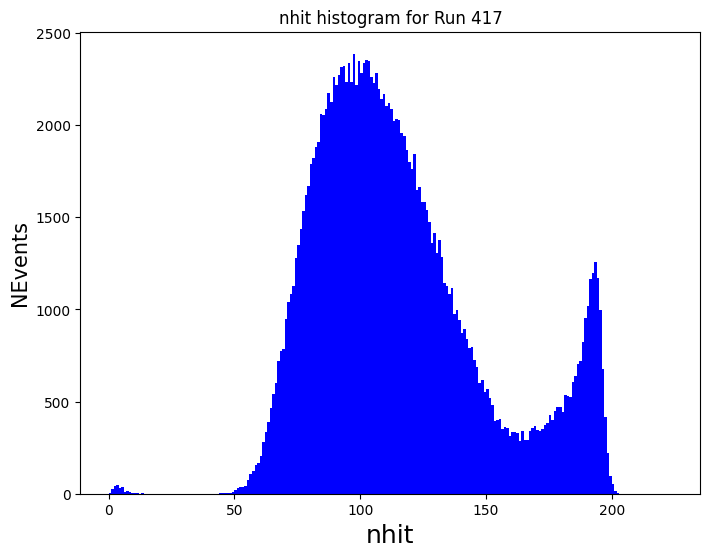

In [4]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#run_number = "312" #
#run_number = "408" #6 hour run with MTCA@120mV prescale of 10
run_number = "417" #6 hour run with no prescale

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
charge = rdf.AsNumpy(columns=["charge"])["charge"]
deltat = rdf.AsNumpy(columns=["deltat"])["deltat"]

nhit_lowDT = []


for iEvt in range(0,len(event_number)):
    if(deltat[iEvt] < 10):
        nhit_lowDT.append(nhit[iEvt]) 


count, bin_edges = np.histogram(nhit_lowDT, bins=np.arange(0,225,1))
bin_centers =[]
for ie in range(1,len(bin_edges)):
    bin_centers.append((bin_edges[ie]+bin_edges[ie-1])/2)


plt.figure(figsize=(8,6))
plt.bar(bin_centers, count, color ='blue', width = 1, label="data")
plt.title("nhit histogram for Run "+run_number)
plt.xlabel("nhit",fontsize=18)
plt.ylabel("NEvents",fontsize=15)

plt.show()

### Plot for total_charge

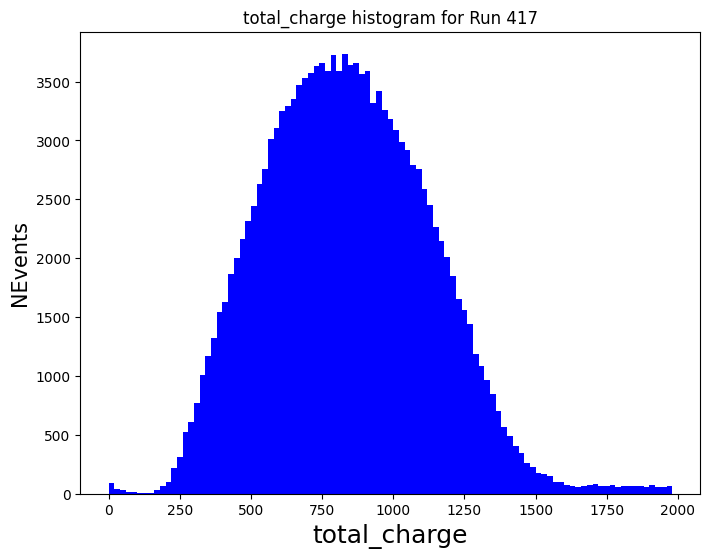

In [5]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#run_number = "312" #
#run_number = "408" #6 hour run with MTCA@120mV prescale of 10
run_number = "417" #6 hour run with no prescale

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
total_charge = rdf.AsNumpy(columns=["total_charge"])["total_charge"]
deltat = rdf.AsNumpy(columns=["deltat"])["deltat"]

nhit_lowDT = []
total_charge_lowDT =[]


for iEvt in range(0,len(event_number)):
    if(deltat[iEvt] < 10):
        nhit_lowDT.append(nhit[iEvt])
        total_charge_lowDT.append(total_charge[iEvt])


count, bin_edges = np.histogram(total_charge_lowDT, bins=np.arange(0,2000,20))
bin_centers =[]
for ie in range(1,len(bin_edges)):
    bin_centers.append((bin_edges[ie]+bin_edges[ie-1])/2)


plt.figure(figsize=(8,6))
plt.bar(bin_centers, count, color ='blue', width = 20, label="data")

plt.title("total_charge histogram for Run "+run_number)
plt.xlabel("total_charge",fontsize=18)
plt.ylabel("NEvents",fontsize=15)

plt.show()

## Let's select on deltaT < 10 then plot the nhit and total_charge of the previous (muon) event.

In [ ]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#run_number = "312" #
#run_number = "408" #6 hour run with MTCA@120mV prescale of 10
run_number = "417" #6 hour run with no prescale

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
total_charge = rdf.AsNumpy(columns=["total_charge"])["total_charge"]
deltat = rdf.AsNumpy(columns=["deltat"])["deltat"]

nhit_prevEvt = []
total_charge_prevEvt =[]


for iEvt in range(0,len(event_number)):
    if(deltat[iEvt] < 10):
        nhit_prevEvt.append(nhit[iEvt-1])
        total_charge_prevEvt.append(total_charge[iEvt-1])


plt.figure(figsize=(8,6))
plt.hist(nhit_prevEvt, color ='blue', bins=range(0,225), label="nhit Prev Event")
plt.title("nhit histogram for the event before low$\Delta$t event for Run "+run_number)
plt.xlabel("nhit",fontsize=18)
plt.ylabel("NEvents",fontsize=15)
plt.yscale('log')
plt.ylim(10,8000)
plt.show()

plt.figure(figsize=(8,6))
plt.hist(total_charge_prevEvt, bins=range(0,8000,10), color ='blue', label="total_charge Prev Event")
plt.title("total_charge histogram for the event before low$\Delta$t event for Run "+run_number)
plt.xlabel("total_charge",fontsize=18)
plt.ylabel("NEvents",fontsize=15)
plt.yscale('log')
plt.ylim(50,800)
plt.show()

## Let's make a 2D distribution of total charge current to total charge previous for event with deltaT < 10.

In [ ]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#run_number = "312" #
#run_number = "408" #6 hour run with MTCA@120mV prescale of 10
run_number = "417" #6 hour run with no prescale

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
total_charge = rdf.AsNumpy(columns=["total_charge"])["total_charge"]
deltat = rdf.AsNumpy(columns=["deltat"])["deltat"]

nhit_prevEvt = []
total_charge_prevEvt =[]
nhit_lowDTEvt = []
total_charge_lowDTEvt =[]


for iEvt in range(0,len(event_number)):
    if(deltat[iEvt] < 10):
        nhit_prevEvt.append(nhit[iEvt-1])
        total_charge_prevEvt.append(total_charge[iEvt-1])
        nhit_lowDTEvt.append(nhit[iEvt])
        total_charge_lowDTEvt.append(total_charge[iEvt])


plt.figure(figsize=(8,6))
plt.hist2d(total_charge_prevEvt,total_charge_lowDTEvt,bins=[range(0,8000,100),range(0,8000,100)],cmap='jet',norm=colors.LogNorm())
plt.title("total_charge of Current Event vs Previous Event when current Event has low$\Delta$t event for Run "+run_number)
plt.xlabel("total_charge_prevEvt",fontsize=18)
plt.ylabel("total_charge_lowDTEvt",fontsize=18)
plt.colorbar()
plt.show()

## Let's make a 2D distribution of total charge current to total charge previous for event with deltaT > 100.

In [ ]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#run_number = "312" #
#run_number = "408" #6 hour run with MTCA@120mV prescale of 10
run_number = "417" #6 hour run with no prescale

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
total_charge = rdf.AsNumpy(columns=["total_charge"])["total_charge"]
deltat = rdf.AsNumpy(columns=["deltat"])["deltat"]

nhit_prevEvt = []
total_charge_prevEvt =[]
nhit_lowDTEvt = []
total_charge_lowDTEvt =[]


for iEvt in range(0,len(event_number)):
    if(deltat[iEvt] > 100):
        nhit_prevEvt.append(nhit[iEvt-1])
        total_charge_prevEvt.append(total_charge[iEvt-1])
        nhit_lowDTEvt.append(nhit[iEvt])
        total_charge_lowDTEvt.append(total_charge[iEvt])


plt.figure(figsize=(8,6))
plt.hist2d(total_charge_prevEvt,total_charge_lowDTEvt,bins=[range(0,8000,100),range(0,8000,100)],cmap='jet',norm=colors.LogNorm())
plt.title("total_charge of Current Event vs Previous Event when current Event has High $\Delta$t event for Run "+run_number)
plt.xlabel("total_charge_prevEvt",fontsize=18)
plt.ylabel("total_charge_HighDTEvt",fontsize=18)
plt.colorbar()
plt.show()

## Let's make a histogram of deltaT for the next event if the current event has an nhit > 150

In [ ]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#run_number = "312" #
#run_number = "408" #6 hour run with MTCA@120mV prescale of 10
run_number = "417" #6 hour run with no prescale

rdf = ROOT.RDataFrame("events","/mnt/data/eos/run"+run_number+"/run"+run_number+".root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
total_charge = rdf.AsNumpy(columns=["total_charge"])["total_charge"]
deltat = rdf.AsNumpy(columns=["deltat"])["deltat"]

deltat_highnhit = []
deltat_lownhit = []


for iEvt in range(0,len(event_number)-1):
    if(nhit[iEvt] > 150):
        deltat_highnhit.append(deltat[iEvt+1])
    else:        
        deltat_lownhit.append(deltat[iEvt+1])


#count, bin_edges = np.histogram(deltat_highnhit, bins=np.arange(0,1000,1))
#bin_centers =[]
#for ie in range(1,len(bin_edges)):
#    bin_centers.append((bin_edges[ie]+bin_edges[ie-1])/2)


plt.figure(figsize=(8,6))

weightsHigh = np.ones_like(deltat_highnhit) / len(deltat_highnhit)
weightsLow = np.ones_like(deltat_lownhit) / len(deltat_lownhit)
plt.hist(deltat_highnhit, bins=range(0,200,2), weights = weightsHigh, alpha=0.5, color ='blue', label="nhit > 150")
plt.hist(deltat_lownhit, bins=range(0,200,2), weights = weightsLow , alpha=0.5, color = 'red', label="nhit < 150")

plt.title("deltat_highnHit histogram for Run "+run_number)
plt.xlabel("$\Delta$t [$\mu$s]",fontsize=18)
plt.ylabel("NEvents",fontsize=15)
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
count, bin_edges = np.histogram(deltat_highnhit, bins=np.arange(0,10,0.1))
bin_centers =[]
for ie in range(1,len(bin_edges)):
    bin_centers.append((bin_edges[ie]+bin_edges[ie-1])/2)


plt.figure(figsize=(8,6))
plt.bar(bin_centers, count, color ='blue', width = 0.1, label="data")

plt.title("deltat_highnHit histogram for Run "+run_number)
plt.xlabel("$\Delta$t [$\mu$s]",fontsize=18)
plt.ylabel("NEvents",fontsize=15)
plt.yscale('log')
plt.show()

## Spacer

# MC Analysis Below

In [ ]:
##################### MC Analysis Below this.
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
f = ROOT.TFile.Open("/mnt/data/eos/simulations/muon/eos_muon_water_trigthres30_70kcomb.root")
output = f.Get("output")
output.Print()

## This block loops over the SIM to see if there's a muon neutrino in the event.
## These events are assumed to be muon decays.

In [ ]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
rdf = ROOT.RDataFrame("output","/mnt/data/eos/simulations/muon/eos_muon_water_trigthres30_70kcomb.root")
mcpdg = rdf.AsNumpy(columns=["mcpdg"])["mcpdg"]
trackPDG = rdf.AsNumpy(columns=["trackPDG"])["trackPDG"]
nhits = rdf.AsNumpy(columns=["nhits"])["nhits"]
hitPMTDigitizedCharge = rdf.AsNumpy(columns=["hitPMTDigitizedCharge"])["hitPMTDigitizedCharge"]

nhitsWithMuNu=[]
hitPMTDigitizedTotalCharge=[]

nEventWithMuNu=0
for iEvt in range(0,len(trackPDG)):
    if(iEvt%1000 == 0): print("Event#:",iEvt)
    
    FoundMuNu = False
    for iTrk in range(0,len(trackPDG[iEvt])):
        
        if(trackPDG[iEvt][iTrk] == 14 or trackPDG[iEvt][iTrk] == -14):
            #print(trackPDG[iEvt][iTrk])
            FoundMuNu = True

    if(FoundMuNu): 
        nEventWithMuNu+=1
        nhitsWithMuNu.append(nhits[iEvt])
        total_charge = 0
        for iPMT in range(0,len(hitPMTDigitizedCharge[iEvt]):
            total_charge += hitPMTDigitizedTotalCharge[iEvt][iPMT]
        hitPMTDigitizedTotalCharge.append(total_charge)
        

plt.hist(nhitsWithMuNu,bins=range(0,225,1))
plt.xlabel("nhits for Run SIM",fontsize=18)
plt.ylabel("NEvents",fontsize=15)
plt.show()
plt.hist(hitPMTDigitizedTotalCharge,bins=range(0,225,1))
plt.xlabel("total_charge for Run SIM",fontsize=18)
plt.ylabel("NEvents",fontsize=15)
plt.show()
print("nEventWithMuNu/nEvent ",nEventWithMuNu/len(trackPDG)) 


## This plots the nhits of the muon SIMS.

In [ ]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

rdf = ROOT.RDataFrame("output","/mnt/data/eos/simulations/muon/eos_muon_water_trigthres30_70kcomb.root")
nhits = rdf.AsNumpy(columns=["nhits"])["nhits"]
plt.hist(nhits,bins=range(0,225))
plt.show()
print(len(nhits))

## This plots the triggerTime of the muon SIMS.

In [ ]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

rdf = ROOT.RDataFrame("output","/mnt/data/eos/simulations/muon/eos_muon_water_trigthres30_70kcomb.root")
triggerTime = rdf.AsNumpy(columns=["triggerTime"])["triggerTime"]
#for iEvt in range(0,100):#len(triggerTime)):
    #for iTrig in range(0,len(
#    print(triggerTime[iEvt])
plt.hist(triggerTime,bins=range(1,35,1))
plt.yscale('log')
plt.show()
